In [2]:
import pandas as pd
import numpy as np
import math
import datetime


In [6]:
pollution = pd.read_csv('pollution_data.csv',sep=",",parse_dates=['TIMESTAMP'])
pollution.head()


,Unnamed: 0,ozone,particullate_matter,carbon_monoxide,sulfure_dioxide,nitrogen_dioxide,TIMESTAMP
0,287,67,114,30,46,151,2014-02-08 00:00:00
1,288,68,119,33,51,153,2014-02-08 00:05:00
2,289,67,117,32,51,153,2014-02-08 00:10:00
3,290,62,122,29,54,154,2014-02-08 00:15:00
4,291,63,124,28,50,152,2014-02-08 00:20:00


In [ ]:
# Reading pollution csv that contains data for 2 months Aug and Sept
pollution = pd.read_csv('pollution_data.csv',sep=",",parse_dates=['TIMESTAMP'])
pollution['TIMESTAMP'] = pd.to_datetime(pollution['TIMESTAMP'])
pollution.set_index('TIMESTAMP', inplace = True)
pollution.head()

,Unnamed: 0,ozone,particullate_matter,carbon_monoxide,sulfure_dioxide,nitrogen_dioxide
TIMESTAMP,,,,,,
2014-02-08 00:00:00,287,67,114,30,46,151
2014-02-08 00:05:00,288,68,119,33,51,153
2014-02-08 00:10:00,289,67,117,32,51,153
2014-02-08 00:15:00,290,62,122,29,54,154
2014-02-08 00:20:00,291,63,124,28,50,152


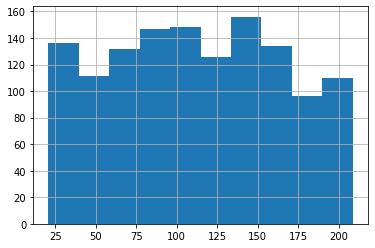

In [ ]:
data  = pollution['1-8-2014':'30-9-2014']
CAQI = pd.DataFrame(columns=['PM', 'NO2'])
CAQI['PM'] = data['particullate_matter'].resample('60T').mean()
CAQI['NO2'] = data['nitrogen_dioxide'].resample('60T').mean()

CAQI['PM'].hist()

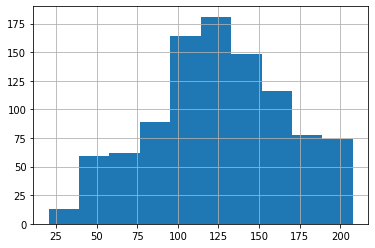

In [ ]:
CAQI['NO2'].hist()

In [ ]:
# European method for calcuating AQI alias CAQI

def get_AQIs(dataframe):
    df = dataframe
    CAQI = pd.DataFrame(columns=['PM', 'NO2'])

    CAQI['PM'] = df['PM'].resample('60T').mean()
    CAQI['NO2'] = df['NO2'].resample('60T').mean()


    CAQI.loc[(CAQI['PM'] > 180) & (CAQI['PM'] <= 250) , 'PM'] = 5000
    CAQI.loc[(CAQI['PM'] > 90) & (CAQI['PM'] <= 180) , 'PM']  = 4000
    CAQI.loc[(CAQI['PM'] > 50) & (CAQI['PM'] <= 90) , 'PM']   = 3000
    CAQI.loc[(CAQI['PM'] > 25) & (CAQI['PM'] <= 50) , 'PM']   = 2000
    CAQI.loc[(CAQI['PM'] > 0) & (CAQI['PM'] <= 25) , 'PM']    = 1000

    CAQI.loc[(CAQI['NO2'] > 400) & (CAQI['NO2'] <= 600) , 'NO2'] = 5000
    CAQI.loc[(CAQI['NO2'] > 200) & (CAQI['NO2'] <= 400) , 'NO2'] = 4000
    CAQI.loc[(CAQI['NO2'] > 100) & (CAQI['NO2'] <= 200) , 'NO2'] = 3000
    CAQI.loc[(CAQI['NO2'] > 50) &  (CAQI['NO2'] <= 100) , 'NO2'] = 2000
    CAQI.loc[(CAQI['NO2'] > 0)  &  (CAQI['NO2'] <= 50) , 'NO2']  = 1000

    conditions = [
    (CAQI['PM'] > CAQI['NO2']), 
    (CAQI['NO2'] > CAQI['PM']),
    (CAQI['NO2'] == CAQI['PM'])]

    choices = [CAQI['PM'], CAQI['NO2'], CAQI['NO2']]

    CAQI['quality'] = np.select(conditions, choices, default=np.nan)
    CAQI['quality'].replace(5000, 'Very High',inplace = True)
    CAQI['quality'].replace(4000, 'High',inplace = True)
    CAQI['quality'].replace(3000, 'Medium',inplace = True)
    CAQI['quality'].replace(2000, 'Low',inplace = True)
    CAQI['quality'].replace(1000, 'Very low',inplace = True)

    CAQI = CAQI.drop(columns=['PM','NO2'])

    CAQI['PM'] = df['PM'].resample('60T').mean()
    CAQI['NO2'] = df['NO2'].resample('60T').mean()

    return CAQI



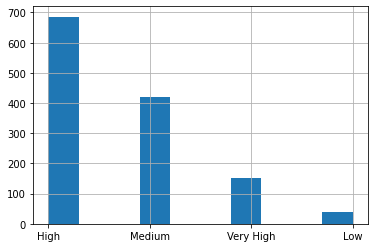

In [ ]:
CAQI = get_AQIs(CAQI)
CAQI['quality'].hist()

In [ ]:
CAQI.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6360 entries, 2014-01-09 00:00:00 to 2014-09-30 23:00:00
Freq: 60T
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   quality  1296 non-null   object 
 1   PM       1296 non-null   float64
 2   NO2      1296 non-null   float64
dtypes: float64(2), object(1)
memory usage: 198.8+ KB


In [ ]:
AQI_data = pd.DataFrame(CAQI, columns=["PM","NO2","quality"])
AQI_data.head()
AQI_data.to_csv("CAQI_data.csv")

# AQI calculation - American method

In [3]:
# American way of calculating AQI : concentration to AQI


def calculate_AQI_ozone(concentration):
    assert concentration >= 0
    assert concentration <= 500
    value = concentration
    concentration_hilo = [(0,54),(55,70),(71,85),(86,105),(106,200),(201,2049)]
    AQI_hilo = [(0,50),(51,100),(101,150),(151,200),(201,300),(301,500)]
    aqi = -1
    for idx, val in enumerate(concentration_hilo):
        if value <= val[1] and value >= val[0] :
            aqi = (AQI_hilo[idx][1] - AQI_hilo[idx][0])/(concentration_hilo[idx][1]-concentration_hilo[idx][0]) * (value - concentration_hilo[idx][0]) + AQI_hilo[idx][0]
            return int(round(aqi))
        
def calculate_AQI_nitrogene(concentration):
    assert concentration >= 0
    assert concentration <= 500
    value = concentration
    concentration_hilo = [(0,53),(54,100),(101,360),(361,649),(650,1294),(1250,2049)]
    AQI_hilo = [(0,50),(51,100),(101,150),(151,200),(201,300),(301,500)]
    aqi = -1
    for idx, val in enumerate(concentration_hilo):
        if value <= val[1] and value >= val[0] :
            aqi = (AQI_hilo[idx][1] - AQI_hilo[idx][0])/(concentration_hilo[idx][1]-concentration_hilo[idx][0]) * (value - concentration_hilo[idx][0]) + AQI_hilo[idx][0]
            return int(round(aqi))


def calculate_AQI_sulfure(concentration):
    assert concentration >= 0
    assert concentration <= 500
    value = concentration
    concentration_hilo = [(0,35),(36,75),(76,185),(186,304),(305,604),(605,1004)]
    AQI_hilo = [(0,50),(51,100),(101,150),(151,200),(201,300),(301,500)]
    aqi = -1
    for idx, val in enumerate(concentration_hilo):
        if value <= val[1] and value >= val[0] :
            aqi = (AQI_hilo[idx][1] - AQI_hilo[idx][0])/(concentration_hilo[idx][1]-concentration_hilo[idx][0]) * (value - concentration_hilo[idx][0]) + AQI_hilo[idx][0]
            return int(round(aqi))

def get_avg_concentration(list_part,times):
    ''' Get average concentration per hour , since we have concentrations each 10 min
    '''
    concentration = 0
    j = 0
    dates_v = []
    for i,val in enumerate(list_part):
        #To GET average concentration for each hour
        k = j
        if k%12 == 0 and j != 0 :
            concentration /= 12
            dates_v.append((times[i-12],concentration))
            concentration = 0
            concentration += int(val) 
        else:
            concentration += int(val)
        
        j+=1
    return dates_v


def get_AQIs(dataframe):
    df = dataframe
    AQI_df = pd.DataFrame()
    ozone = df['ozone'].to_list()
    nitrogene = df['nitrogen_dioxide'].to_list()
    sulfure = df['sulfure_dioxide'].to_list()

    times = df['TIMESTAMP'].to_list()

    AQI_hilo = [(0,50),(51,100),(101,150),(151,200),(201,300),(301,500)]
    aqi_v = ["Good","Moderate","Unhealthy for sensitive","Unhealthy","Very unhealthy","Hazardous"]
    
    concentration_o_hourly = get_avg_concentration(ozone,times)
    concentration_n_hourly  = get_avg_concentration(nitrogene,times)
    concentration_s_hourly  = get_avg_concentration(sulfure,times)
    print(concentration_o_hourly[:3])
    # Now we got the average concentration for each hour we will calculate the Hourly AQI
    # https://forum.airnowtech.org/t/daily-and-hourly-aqi-ozone/170
    k = 4
    idx = 0
    concentration_o = [i[1] for i in concentration_o_hourly]
    concentration_n = [i[1] for i in concentration_n_hourly]
    concentration_s = [i[1] for i in concentration_s_hourly]

    AQI_dates = []
    conc_ozone = []
    while k >3 and k < (len(concentration_o)-3): 
        avg_con_o = np.mean(concentration_o[idx:idx+8]) 
        avg_con_n = np.mean(concentration_n[idx:idx+8])
        avg_con_s = np.mean(concentration_s[idx:idx+8])

        aqi_o = calculate_AQI_ozone(int(avg_con_o))
        aqi_n=calculate_AQI_nitrogene(int(avg_con_n))
        aqi_s= calculate_AQI_sulfure(int(avg_con_s))
        
        aqi = max([aqi_o,aqi_n,aqi_s])
        for pos, aqival in enumerate(AQI_hilo):
            if aqival[0] <= int(aqi) and int(aqi) <= aqival[1]:
                goodness= aqi_v[pos]
        AQI_dates.append((concentration_o_hourly[k][0],avg_con_o,avg_con_n,avg_con_s,aqi,goodness))
        k+= 1
        idx +=1
        goodness ="Hazardous"
        
    return AQI_dates


In [4]:
calculate_AQI_sulfure(73)

97

In [7]:
aqi_hourly = get_AQIs(pollution)

[(Timestamp('2014-02-08 00:00:00'), 67.16666666666667), (Timestamp('2014-02-08 01:00:00'), 67.5), (Timestamp('2014-02-08 02:00:00'), 67.66666666666667)]


In [ ]:
AQI_data = pd.DataFrame(aqi_hourly, columns=["TIMESTAMP","Ozone","nitrogene","sulfure","AQI","Goodness"])
AQI_data.head()
AQI_data.to_csv("AQI_data_new.csv")